In [1]:
import os
import re

import matplotx
import pandas as pd

from processor.filters import cut_by_window
from utils import load_df_with_time_index
import matplotlib.pyplot as plt
from typing import Callable
import pickle as pkl
import seaborn as sns

In [2]:
def extract_fields(meta):
    match = re.search(r'{__name__="([^"]+)", group="::([^"]+)", scenario="([^"]+)"}', meta)
    if match:
        return match.group(1), match.group(2), match.group(3)
    return None, None, None


def get_os_and_processor(name: str) -> tuple[str, str]:
    os = "Windows" if "perfw" in name.lower() else "Linux"
    processor = "AMD" if "amd" in name.lower() else "Intel"
    return os, processor

In [3]:
def merge_dashboards(stored_data: dict[str, dict], dashboard_name: str, loader: Callable[[str], pd.DataFrame]):
    dfs = []
    for data in stored_data.values():
        vus = data["vus"]
        test_instance, identifier = data["instance_identifier"]
        dashboards = data["dashboards"]
        df = loader(dashboards[dashboard_name])
        df = df.melt(var_name='meta', value_name='value', ignore_index=False)
        df[['count_name', 'group', 'scenario']] = df['meta'].apply(lambda x: pd.Series(extract_fields(x)))
        df["vus"] = vus
        df["instance"] = "{} {}".format(*get_os_and_processor(test_instance))
        df["identifier"] = identifier
        df["os"], df["processor"] = get_os_and_processor(test_instance)
        # Apply extract_fields to the 'meta' column
        dfs.append(df)

    merged = pd.concat(dfs)
    merged = merged.sort_index()
    merged = merged.reset_index().set_index("Time")

    return merged

In [4]:
def save_plot_if_new(filename: str, dpi: int = 300, style: str = matplotx.styles.dracula, force: bool = False):
    """
    Save the current matplotlib figure to `filename` only if it does not exist.
    """
    if force and os.path.exists(filename):
        os.remove(filename)

    if not os.path.exists(filename):
        if style:
            with plt.style.context(style):
                plt.savefig(filename, dpi=dpi, transparent=True)
        else:
            plt.savefig(filename, dpi=dpi, transparent=True)
        print(f"Plot saved to {filename}")

In [5]:
data_ = pkl.load(open("results/quick_data.pkl", "rb"))

In [6]:
group_duration = merge_dashboards(data_, "Group Duration", load_df_with_time_index)

In [7]:
group_duration[group_duration["instance"] == "Windows AMD"].index.max()

Timedelta('0 days 01:09:30')

In [8]:
cut_by_window(group_duration[group_duration['scenario'] == 'SalesOrderEntry'], "20m","40m")["instance"].unique()

array(['Windows AMD', 'Linux AMD'], dtype=object)

In [9]:
sales_order_entry = group_duration[group_duration['scenario'] == 'SalesOrderEntry']
sales_order_entry.loc[:,"group"] = sales_order_entry["group"].apply(lambda x: x.split("_")[-1])
sales_order_entry = sales_order_entry[["value","group","scenario","instance"]]

In [10]:
sales_order_entry["group"].unique()

array(['GetNewOrderHed', 'GetNewOrderDtl', 'GetList', 'GetByID',
       'CheckForFirmJob', 'ChangeSellingQtyMaster', 'ChangeRequestDate',
       'ChangePartNumMaster', 'ChangeOrderHedCustomerCustID',
       'GetNewParameters', 'SetPrintInventoryAttributes', 'XbSysts',
       'MasterUpdate'], dtype=object)

In [11]:
group_duration["group"].unique()

array(['BAQDesigner', 'PartTracker_GlbPartsExist',
       'PartTracker_GetRowsPerPlantKinetic',
       'MiscARInvoice_OnChangeofLineQty', 'PartTracker_GetPartXRefInfo',
       'PartTracker_GetPartUOMPlasticTax',
       'MiscARInvoice_OnChangeofSoldToCustID',
       'PartTracker_GetListAndOrderAllocationGetRows',
       'PartTracker_GetFullBinSearch', 'MiscARInvoice_PrePostInvoices',
       'PartTracker_GetByID', 'PartMaintenance_Update',
       'MiscARInvoice_PrePrintInvoices',
       'PartMaintenance_PartUOMPlasticTaxUpdate',
       'PartMaintenance_InitializeTracker', 'MiscARInvoice_PreUpdate',
       'PartMaintenance_GlbPartsExist', 'PartMaintenance_GetRows',
       'PartMaintenance_GetPartXRefInfo',
       'MiscARInvoice_SetReadyToCalcEx',
       'MiscARInvoice_OnChangeofLinePartNum',
       'PartMaintenance_GetPartUOMPlasticTax',
       'PartTracker_ImageSvc_GetRows', 'MiscARInvoice_GetRowsNoLock',
       'QuoteEntry_GetNewQuoteHed', 'MiscARInvoice_GetNewInvcDtl',
       'QuoteEnt

In [12]:
sales_order_entry = sales_order_entry[sales_order_entry['group'].isin(['GetNewOrderHed','MasterUpdate','GetByID'])]
sales_order_entry['value'] = pd.to_numeric(sales_order_entry['value'], errors='coerce')
sales_order_entry = cut_by_window(sales_order_entry, "20m","40m")

In [13]:
sales_order_entry.describe()

,value
count,966.000000
mean,2.935890
std,0.555722
min,2.230000
25%,2.340000
50%,2.850000
75%,3.440000
max,3.920000


In [14]:
def plot_over_time(df: pd.DataFrame, y_col: str, title: str, ylabel: str, grouper: str = "instance",
                   ax: plt.Axes | None = None):

    instances = df[grouper].unique()
    palette = dict(zip(instances, sns.color_palette("tab10", len(instances))))
    if ax is None:
        fig, ax = plt.subplots(figsize=(7.5, 5))
    for name, group in df.groupby(grouper):
        color = palette.get(name)
        group.plot(use_index=True, y=y_col, label=name, ax=ax, color=color)
    plt.title(title)
    plt.ylabel(ylabel)
    if ax is None:
        plt.show()

In [15]:
sales_order_entry["instance"].unique()

array(['Linux AMD', 'Windows AMD'], dtype=object)

Plot saved to results/sales_order_entry_groups_duration_over_time.png


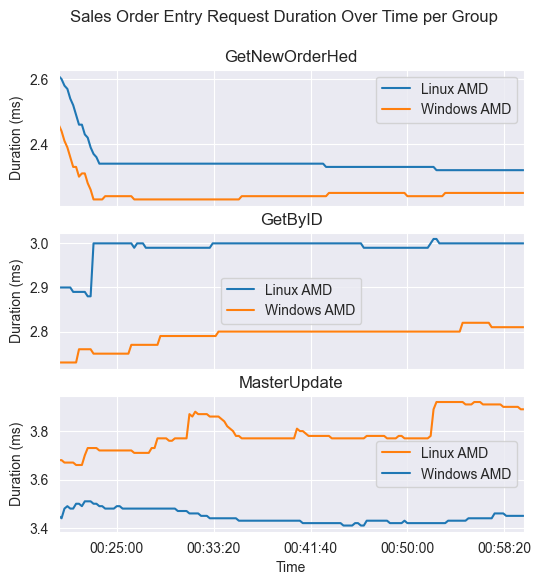

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(6, 6))
fig.suptitle("Sales Order Entry Request Duration Over Time per Group")
for i,group in enumerate(sales_order_entry['group'].unique()):
    ax = axs[i]
    to_plot = sales_order_entry[sales_order_entry['group'] == group]
    plot_over_time(to_plot, 'value', f'{group} Duration Over Time', 'Duration (ms)', ax=ax)
    ax.set_title(f'{group}')
    ax.set_ylabel('Duration (ms)')
    if i < len(axs) - 1:
        ax.tick_params(labelbottom=False)
        ax.set_xlabel('')
save_plot_if_new("results/sales_order_entry_groups_duration_over_time.png")